# General trace loader
Interface for loading various traces. Tasks include:
- Resolving class imbalance (TODO)
- Noise reduction (TODO)

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np

from tools.cache import cache_np
from tqdm import tqdm
from tools.traceloader import ASCAD, TraceGroup

sns.set_style("whitegrid")

KEY_SIZE = 256
TRACE_LEN = 1400

In [5]:
ascad = ASCAD()
ascad.default.profile.traces.shape

(200000, 1400)

In [6]:
ascad.default.profile.filter_traces(1).shape

(768, 1400)

<AxesSubplot:>

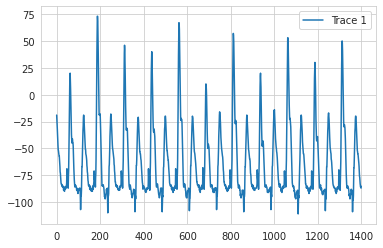

In [7]:
T1 = ascad.default.profile.traces[0]
sns.lineplot(data=pd.DataFrame(T1, columns=["Trace 1"]))

### Plot of a small section of two traces

<AxesSubplot:>

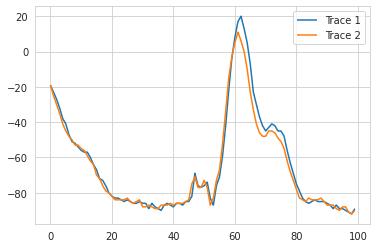

In [8]:
T2 = ascad.default.profile.traces[1]
sns.lineplot(dashes=[(1, 0), (1, 0)], data=pd.DataFrame(list(zip(T1, T2))[:100], columns=["Trace 1", "Trace 2"]))

### Mean of ASCAD traces.

In [9]:
print(f"Profiling trace mean: {ascad.default.profile.traces.mean():.2f},\n"
      f"Attack trace mean: {ascad.default.attack.traces.mean():.2f}")

Profiling trace mean: -63.59,
Attack trace mean: -63.67


### Variance of ASCAD traces.

In [10]:
print(f"Profiling trace variance: {ascad.default.profile.traces.var():.2f},\n"
      f"Attack trace variance: {ascad.default.attack.traces.var():.2f}")

Profiling trace variance: 1149.78,
Attack trace variance: 1138.65


### Mean and variance between all traces.

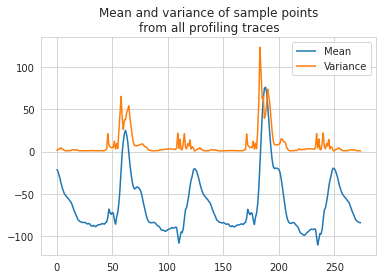

In [11]:
import matplotlib.pyplot as plt

DEFAULT_CUTOFF = 275

def plot_mv_traces(traces, cutoff=DEFAULT_CUTOFF):
    df_mv = pd.DataFrame(list(zip(traces.mean(axis=0), traces.var(axis=0)))[:cutoff], columns=["Mean", "Variance"])

    title = "Mean and variance of sample points\nfrom all profiling traces"
    sns.lineplot(dashes=[(1, 0), (1, 0)], data=df_mv).set_title(title)

def mv_diff(left, right):
    mean_diff = left.mean(axis=0) - right.mean(axis=0)
    var_diff = left.var(axis=0) - right.var(axis=0)

    return mean_diff, var_diff

def plot_mv_diff(left, right, title, cutoff=DEFAULT_CUTOFF):
    cols = ["Mean difference", "Variance difference"]
    df_mv_diff = pd.DataFrame(list(zip(*mv_diff(left, right)))[:cutoff], columns=cols)
    sns.lineplot(data=df_mv_diff[cols[0]])

    ax2 = plt.twinx()
    sns.lineplot(data=df_mv_diff[cols[1]], color=sns.color_palette()[1], ax=ax2).set_title(title)


plot_mv_traces(ascad.default.profile.traces)

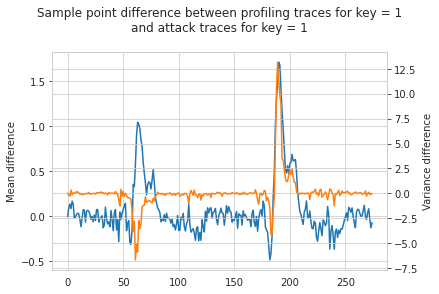

In [12]:
TITLE = "Sample point difference between profiling traces for key = 1\nand attack traces for key = 1\n"
plot_mv_diff(ascad.default.profile.filter_traces(1), ascad.default.attack.filter_traces(1), TITLE)


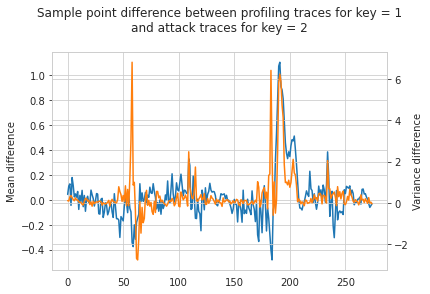

In [13]:
TITLE = "Sample point difference between profiling traces for key = 1\nand attack traces for key = 2\n"
plot_mv_diff(ascad.default.profile.filter_traces(1), ascad.default.attack.filter_traces(2), TITLE)

# Finding Points of Interest

In [14]:
from scipy.stats import skew, kurtosis

def stat_order(a: np.array, order):
    if order == 1:
        return a.mean(axis=0)
    if order == 2:
        return a.var(axis=0)
    if order == 3:
        return skew(a, axis=0)
    if order == 4:
        return kurtosis(a, axis=0)

    Exception(f"Order not implemented: {order}")

### Order difference detection tool

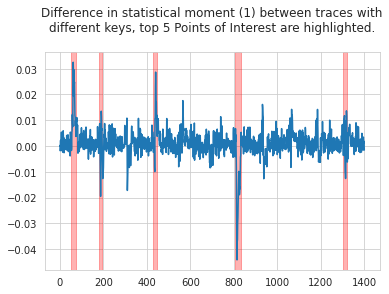

array([[ 804,  831],
       [  50,   74],
       [ 429,  447],
       [1303, 1319],
       [ 179,  194]])

In [15]:
def calc_moment_difference(tg: TraceGroup, moment=1, use_attack=False):
    kr = range(KEY_SIZE)

    if use_attack:
        traces_left = [stat_order(tg.profile.filter_traces(k), moment) for k in kr]
        traces_right = [stat_order(tg.attack.filter_traces(k), moment) for k in kr]
    else:
        traces_left, traces_right = [], []
        tc = tg.profile

        for k in kr:
            traces = tc.filter_traces(k)
            mid = round(len(traces) / 2)
            traces_left.append(stat_order(traces[mid:], moment))
            traces_right.append(stat_order(traces[:mid], moment))

    cross = []
    for i in kr:
        for j in kr:
            if i != j:
                cross.append(abs(traces_left[i] - traces_right[j]))

    mean_diff_neq = np.mean(cross, axis=0)
    mean_diff_eq = np.mean([abs(traces_left[i] - traces_right[i]) for i in kr], axis=0)

    return mean_diff_neq - mean_diff_eq

def get_moment_differences(db, use_attack=False, trace_size=1400, max_moment=3):
    mdiff = [calc_moment_difference(db.default, i, use_attack) for i in range(1, max_moment + 1)]

    return np.array([np.zeros(trace_size), *mdiff])

MOMENT_DIFFERENCES = cache_np("moment_differences", get_moment_differences, ascad, v=2)
TRUE_MDIFF = cache_np("true_moment_differences", get_moment_differences, ascad, True, v=1)

# TODO try window = 100, strange result.
def select_poi(moment_difference, n=5, window=15):
    """
    Selects the top n most interesting points of interest, based on some statistical moment difference.
    """
    diff = abs(moment_difference)
    std = np.std(diff)
    ts = [*(diff > std), *([False] * window)]

    acc = []
    counter, sum_diff, max_diff = 0, 0.0, 0.0
    for ix in range(len(ts)):
        if ts[ix]:
            counter += 1
            sum_diff += diff[ix]
            max_diff = max(diff[ix], max_diff)

        elif counter >= window:
            avg_diff = sum_diff / counter
            acc.append((ix - counter, ix, avg_diff))
            counter, sum_diff, max_diff = 0, 0.0, 0.0

    if len(acc) == 0:
        return []

    return pd.DataFrame(acc).sort_values(2, ascending=False).head(n)[[0,1]].values

def plot_poi(mdiff, moment):
    fig, ax = plt.subplots()
    top_n = 5

    title = f"Difference in statistical moment ({moment}) between traces with\ndifferent keys, " \
            f"top {top_n} Points of Interest are highlighted.\n"
    sns.lineplot(data=mdiff[moment]).set_title(title)

    for a, b in select_poi(mdiff[moment], top_n):
        ax.axvspan(a, b, alpha=0.3, color='red')

    plt.show()

plot_poi(MOMENT_DIFFERENCES, 1)
select_poi(MOMENT_DIFFERENCES[1])

### PoI for the variance

`TODO` What does the big spike at 200 mean?

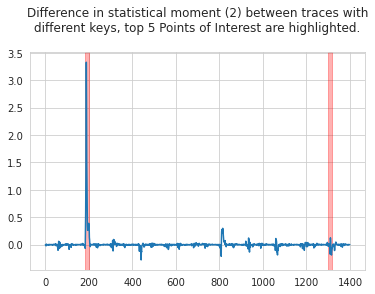

In [16]:
plot_poi(MOMENT_DIFFERENCES, 2)

### PoI for the skewness

`TODO` How to improve the PoI selection?

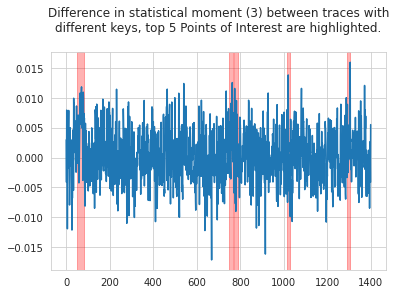

In [17]:
plot_poi(MOMENT_DIFFERENCES, 3)

### Close up of the first PoI

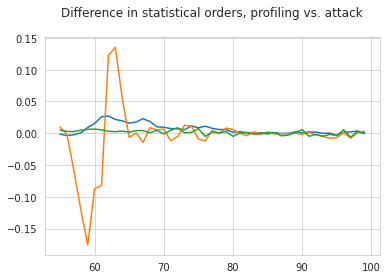

In [18]:
def select_range(line, a=55, b=100):
    return dict(zip(range(a, b), line[a:b]))

sns.lineplot(data=select_range(TRUE_MDIFF[1])).set_title(
    "Difference in statistical orders, profiling vs. attack\n")
sns.lineplot(data=select_range(TRUE_MDIFF[2]))
sns.lineplot(data=select_range(TRUE_MDIFF[3]))

print()

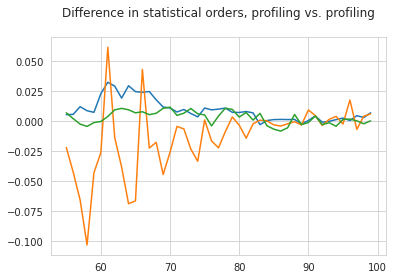

In [19]:
sns.lineplot(data=select_range(MOMENT_DIFFERENCES[1])).set_title(
    "Difference in statistical orders, profiling vs. profiling\n")
sns.lineplot(data=select_range(MOMENT_DIFFERENCES[2]))
sns.lineplot(data=select_range(MOMENT_DIFFERENCES[3]))

print()

# TVLA

### Implementation of $\chi^2$-test

In [20]:
import scipy.stats as stats

def count(traces, poi=None, trace_range=256, offset=-.5, max_bins=64):
    pos_traces = traces + round(-trace_range * offset)

    if poi is None:
        poi = (0, traces.shape[1])

    bin_count = np.sum(np.array([np.bincount(sample_pts[poi[0]:poi[1]], minlength=trace_range) for sample_pts in pos_traces]), axis=0)

    res = np.zeros(max_bins)
    step = round(trace_range / max_bins)

    for ix in range(max_bins):
        res[ix] = np.sum(bin_count[ix * step:(ix + 1) * step])

    return res


### Test examples from paper
Moriadi et al. (2018), page 214


In [21]:
# Example values from Moriadi et al. (2018), page 214
MORIADI = {
    'F_0': [24, 59, 28, 9],
    'F_1': [23, 57, 20, 0],
    'chi': 8.64,
    'dof': 3,
    'p': 0.0345,
    'p_decimal': 3
}

### Implementation based on paper
Moriadi et al. (2018), page 213

In [22]:
import math
from scipy.integrate import quad
from numpy.testing import assert_almost_equal as almost_equal

def f_chi(x, v):
    if x <= 0:
        return 0

    num = x ** ((v / 2) - 1) * math.e ** (-x / 2)
    den = 2 ** (v / 2) * math.gamma(v / 2)
    return num / den

def p_chi(sum_chi, dof):
    return quad(f_chi, sum_chi, np.inf, args=(dof, ))[0]

almost_equal(p_chi(MORIADI['chi'], MORIADI['dof']), MORIADI['p'], MORIADI['p_decimal'])

def chi_squared(observed, expected, balance=False):
    categories = np.array([observed, expected])

    # Expected frequency
    sum_cat = np.sum(observed), np.sum(expected)

    sum_oe = np.sum(categories, axis=0)

    sum_all = np.sum(sum_oe)
    nz_ixs = np.nonzero(sum_oe)[0]

    chi_acc = 0.0
    for cat in range(len(categories)):
        for ix in nz_ixs:
            # Expected frequency
            ef = (sum_cat[cat] * sum_oe[ix]) / sum_all
            # Accumulation of chi-squared value
            chi_acc += (categories[cat][ix] - ef) ** 2 / ef

    # Degrees of freedom.
    dof = (len(nz_ixs) - 1) * (len(categories) - 1)

    # return chi_acc, dof
    return p_chi(chi_acc, dof)

almost_equal(chi_squared(MORIADI['F_0'], MORIADI['F_1']), MORIADI['p'], MORIADI['p_decimal'])


### Application of $\chi^2$ on ASCAD

In [23]:
def v_count(traces, offset=-.5, trace_range=KEY_SIZE):
    traces = np.moveaxis(traces, 0, -1)
    pos_traces = traces + round(-trace_range * offset)

    return [np.bincount(t, minlength=trace_range) for t in pos_traces]

VC1P = v_count(ascad.default.profile.filter_traces(1))
VC1A = np.array(v_count(ascad.default.attack.filter_traces(1))) * 2
VC2P = v_count(ascad.default.profile.filter_traces(2))

In [24]:
np.sum(VC1A[0]), np.sum(VC1P[0]), np.sum(VC2P[0])

(770, 768, 782)

In [66]:
def chi_sample_point(tg: TraceGroup, ks=KEY_SIZE):
    counts_prof = [v_count(tg.profile.filter_traces(i)) for i in range(ks)]
    counts_att = [v_count(tg.attack.filter_traces(i)) * 2 for i in range(ks)]

    csp = np.array([[np.zeros(TRACE_LEN)] * ks] * ks)
    for i in tqdm(range(ks)):
        for j in range(ks):
            csp[i][j] = [chi_squared(counts_prof[i][ix], counts_att[j][ix]) for ix in range(TRACE_LEN)]

    return csp

CSP = chi_sample_point(ascad.default, 20)

100%|██████████| 20/20 [01:57<00:00,  5.90s/it]


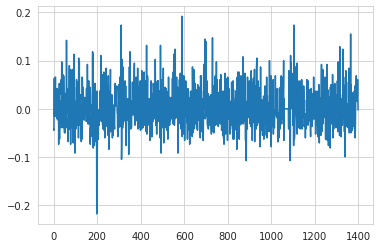

In [73]:
def csp_plot(csp):
    nk = csp.shape[0]

    neq = np.array(np.ones([nk] * 2) - np.identity(nk), dtype=bool)
    eq = np.array(np.identity(nk), dtype=bool)

    sum_eq = np.mean(np.less(csp[eq], .05), axis=0)
    sum_neq = np.mean(np.less(csp[neq], .05), axis=0)
    sns.lineplot(data=(sum_eq - sum_neq))

csp_plot(CSP)